<a href="https://colab.research.google.com/github/sirsjosh/Computer-Vision/blob/main/day-night-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Day and Night Image Classifier**


---
The day/night image dataset consists of 200 RGB color images in two categories: day and night. There are equal numbers of each example: 100 day images and 100 night images.

We'd like to build a classifier that can accurately label these images as day or night, and that relies on finding distinguishing features between the two types of images!

Note: All images come from the AMOS dataset (Archive of Many Outdoor Scenes).

# **Import resources**

Before you get started on the project code, import the libraries and resources that you'll need.

In [1]:
# Helper functions

import os
import glob # library for loading images from a directory
import matplotlib.image as mpimg

import cv2



# This function loads in images and their labels and places them in a list
# The list contains all images and their associated labels
# For example, after data is loaded, im_list[0][:] will be the first image-label pair in the list
def load_dataset(image_dir):

    # Populate this empty image list
    im_list = []
    image_types = ["day", "night"]

    # Iterate through each color folder
    for im_type in image_types:

        # Iterate through each image file in each image_type folder
        # glob reads in any image with the extension "image_dir/im_type/*"
        for file in glob.glob(os.path.join(image_dir, im_type, "*")):

            # Read in the image
            im = mpimg.imread(file)

            # Check if the image exists/if it's been correctly read-in
            if not im is None:
                # Append the image, and it's type (red, green, yellow) to the image list
                im_list.append((im, im_type))

    return im_list



## Standardize the input images
# Resize each image to the desired input size: 600x1100px (hxw).

## Standardize the output
# With each loaded image, we also specify the expected output.
# For this, we use binary numerical values 0/1 = night/day.


# This function should take in an RGB image and return a new, standardized version
# 600 height x 1100 width image size (px x px)
def standardize_input(image):

    # Resize image and pre-process so that all "standard" images are the same size
    standard_im = cv2.resize(image, (1100, 600))

    return standard_im


# Examples:
# encode("day") should return: 1
# encode("night") should return: 0
def encode(label):

    numerical_val = 0
    if(label == 'day'):
        numerical_val = 1
    # else it is night and can stay 0

    return numerical_val

# using both functions above, standardize the input images and output labels
def standardize(image_list):

    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # Create a numerical label
        binary_label = encode(label)

        # Append the image, and it's one hot encoded label to the full, processed list of image data
        standard_list.append((standardized_im, binary_label))

    return standard_list

In [2]:
import cv2 # computer vision library

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# **Training and Testing Data**

The 200 day/night images are separated into training and testing datasets.


*   60% of these images are training images, for you to use as you create a classifier.
*   40% are test images, which will be used to test the accuracy of your classifier.

First, we set some variables to keep track of some where our images are stored:

image_dir_training: the directory where our training image data is stored

image_dir_test: the directory where our test image data is stored

In [3]:
# Image data directories

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

image_dir_training = "/content/drive/My Drive/day-night-dataset/train/"
image_dir_test = "/content/drive/My Drive/day-night-dataset/test/"

# image_dir_training = "https://drive.google.com/drive/folders/1MNQG8LOXuI8bZGbciXlGlR1hES0XqbNR?usp=drive_link"
# image_dir_test = "day_night_images/test/"

Mounted at /content/drive/


# **Load the datasets**

These first few lines of code will load the training day/night images and store all of them in a variable, IMAGE_LIST. This list contains the images and their associated label ("day" or "night").

For example, the first image-label pair in IMAGE_LIST can be accessed by index:  IMAGE_LIST[0][:].

In [4]:
# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST = load_dataset(image_dir_training)

# **Construct a STANDARDIZED_LIST of input images and output labels.**

This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and numerical labels.

In [6]:
# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

# **Visualize the standardized data**

Display a standardized image from STANDARDIZED_LIST.

Shape: (600, 1100, 3)
Label [1 = day, 0 = night]: 1


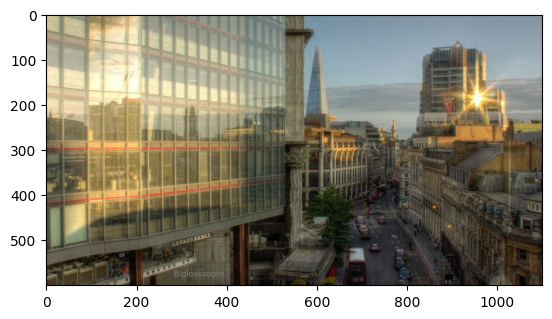

In [7]:
# Display a standardized image and its label

# Select an image by index
image_num = 0
selected_image = STANDARDIZED_LIST[image_num][0]
selected_label = STANDARDIZED_LIST[image_num][1]

# Display image and data about it
plt.imshow(selected_image)
print("Shape: "+str(selected_image.shape))
print("Label [1 = day, 0 = night]: " + str(selected_label))

# **Feature Extraction**

Create a feature that represents the brightness in an image. We'll be extracting the average brightness using HSV colorspace. Specifically, we'll use the V channel (a measure of brightness), add up the pixel values in the V channel, then divide that sum by the area of the image to get the average Value of the image.



---

**Find the average brigtness using the V channel**

This function takes in a standardized RGB image and returns a feature (a single value) that represent the average level of brightness in the image. We'll use this value to classify the image as day or night.




In [8]:
# Find the average Value or brightness of an image
def avg_brightness(rgb_image):
    # Convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    # Add up all the pixel values in the V channel
    sum_brightness = np.sum(hsv[:,:,2])
    area = 600*1100.0  # pixels

    # find the avg
    avg = sum_brightness/area

    return avg

Avg brightness: 24.976186363636362


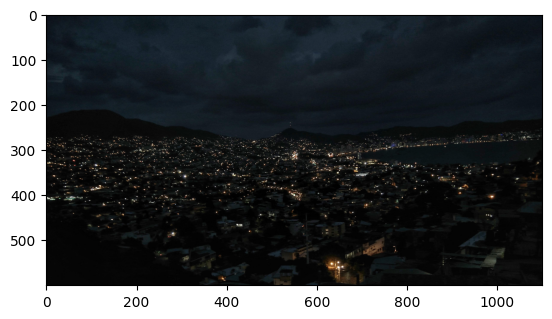

In [9]:
# Testing average brightness levels
# Look at a number of different day and night images and think about
# what average brightness value separates the two types of images

# As an example, a "night" image is loaded in and its avg brightness is displayed
image_num = 190
test_im = STANDARDIZED_LIST[image_num][0]

avg = avg_brightness(test_im)
print('Avg brightness: ' + str(avg))
plt.imshow(test_im)

# **Classification and Visualizing Error**

In this section, we'll turn our average brightness feature into a classifier that takes in a standardized image and returns a predicted_label for that image. This estimate_label function should return a value: 0 or 1 (night or day, respectively).



---

## **Build a complete classifier**

Complete this code so that it returns an estimated class label given an input RGB image.



In [10]:
# This function should take in RGB image input
def estimate_label(rgb_image):

    # Extract average brightness feature from an RGB image
    avg = avg_brightness(rgb_image)

    # Use the avg brightness feature to predict a label (0, 1)
    predicted_label = 0
    threshold = 120
    if(avg > threshold):
        # if the average brightness is above the threshold value, we classify it as "day"
        predicted_label = 1
    # else, the pred-cted_label can stay 0 (it is predicted to be "night")

    return predicted_label


# **Testing the classifier**

Here is where we test your classification algorithm using our test set of data that we set aside at the beginning of the notebook!

Since we are using a pretty simple brightess feature, we may not expect this classifier to be 100% accurate. We'll aim for around 75-85% accuracy usin this one feature.

## **Test dataset**

Below, we load in the test dataset, standardize it using the standardize function you defined above, and then shuffle it; this ensures that order will not play a role in testing accuracy.

In [12]:
import random

# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = load_dataset(image_dir_test)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

# **Determine the Accuracy**

Compare the output of your classification algorithm (a.k.a. your "model") with the true labels and determine the accuracy.

This code stores all the misclassified images, their predicted labels, and their true labels, in a list called misclassified.

In [13]:
# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)

        # Compare true and predicted labels
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))

    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels

In [14]:
# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

Accuracy: 0.885
Number of misclassified images = 23 out of 200




---

# **Visualize the misclassified images**

Visualize some of the images you classified wrong (in the MISCLASSIFIED list) and note any qualities that make them difficult to classify. This will help you identify any weaknesses in your classification algorithm.




0


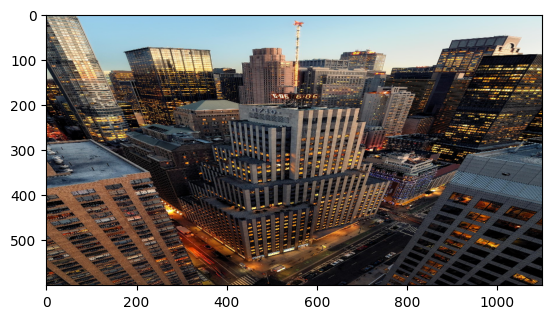

In [15]:
# Visualize misclassified example(s)
## TODO: Display an image in the `MISCLASSIFIED` list
## TODO: Print out its predicted label - to see what the image *was* incorrectly classified as5
num = 0
test_mis_im = MISCLASSIFIED[num][0]
plt.imshow(test_mis_im)
print(str(MISCLASSIFIED[num][1]))